# 📓 Notebook 4: Neural Networks

In this notebook, we will use TensorFlow to build a simple **neural network** that predicts to predict the Air Quality (Status) based on some features from **Taiwan Air Quality Index Data 2016~2024**.

**ATTENTION**
For this notebook I suggest to activate GPU environment. Using only the CPU would make training very slow.
1. At the top right of the page, click on the down arrow next to the RAM and disk statistics.
2. Select "Change runtime type" and ensure that T4 GPU is selected.


## Roadmap
### Data Cleaning
- Normalize column names (no spaces or dots).
- Convert date to datetime format (useful for analysis/features, but not directly used in the model).
- Exclude identifying or textual columns not useful for prediction (sitename, county, siteid, pollutant, unit, aqi).
- Handle missing values: the file may contain placeholders like ND, NA, -, null --> we will treat them as NaN.
- Keep only rows/columns that are informative for the model.

### Notebook Pipeline
- Data loading & cleaning (rename columns, handle missing/empty columns).
- Target preparation and stratified split into train/validation/test sets.
- Preprocessing of numerical features (scaling).
- Modeling using a dense neural network (Keras).

### Evaluation with:
- Accuracy and Balanced Accuracy
- Classification Report (precision/recall/F1)
- Normalized Confusion Matrix
- Diagnostics: loss and val_accuracy curves to assess overfitting/underfitting



## 1. Initial Setup

 We import the necessary libraries for file management, data analysis, visualization, machine learning (scikit-learn), and deep learning (TensorFlow).

**Tools Used**
*   File system: os.
*   Data analysis: pandas, numpy.
*   Visualization: matplotlib, seaborn.
*   Preprocessing: LabelEncoder (label encoding), StandardScaler (scaling).
*   Splitting and metrics: train_test_split, confusion_matrix.
* Utilities: to_categorical (one-hot encoding)
*   Deep learning: tensorflow (layers, optimizers).


In [ ]:
!pip install tensorflow  # O la versione che vuoi usare

In [4]:
# Import of libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score


import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import callbacks
from keras.utils import to_categorical

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


### Loading the Dataset

- Load the CSV file containing air quality data


In [6]:
from google.colab import drive
drive.mount('/content/drive')

cwd = 'drive/MyDrive/es_python' # Set your current working directory where the csv file is located

# Check if file exists
file_path = cwd + '/air_quality.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The CSV file was not found at the path: {file_path}")

# Load dataset (first 300,000 rows for testing)
df = pd.read_csv(file_path, low_memory=False, na_values=['-', 'NA', 'n/a', 'ND',''], nrows=300000)

Mounted at /content/drive


# 2. Data Cleaning

- Declare common placeholders for missing values (ND, NA, -, null) to be converted into NaN.
- Check the data types of the columns.
- Inspect the distinct values of the target variable status.
- Display a sample of the rows to understand the dataset structure.

What to Observe
- *Dimensions:* This helps estimate training time.
- *Data types:* Many columns may be float or int; any object types likely indicate text or numbers read as strings.
- *Target status:* The distinct values tell us which classes we’ll be predicting. Later, we will map them to numeric indices for the model, but in final plots we will display the class names for readability.
- *Missing values:* Defining na_values ensures that placeholders like ND don’t remain as strings, making the cleaning process consistent.



In [ ]:
# Let's check that the column type has been read correctly
print(df.dtypes)

# Target to be predicted
target = "status"

# Drop rows with missing target
df = df.dropna(subset=[target])

print("\nUnique values in the 'status' column after initial loading:")
class_names = df['status'].unique()
num_classes=len(df['status'].unique())
print(class_names)
print("\nNumber of classes:", num_classes)

# display the first 5 rows
df.head()

date          object
sitename      object
county        object
aqi          float64
pollutant     object
status        object
so2          float64
co           float64
o3           float64
o3_8hr       float64
pm10         float64
pm2.5        float64
no2          float64
nox          float64
no           float64
windspeed    float64
winddirec    float64
unit         float64
co_8hr       float64
pm2.5_avg    float64
pm10_avg     float64
so2_avg      float64
longitude    float64
latitude     float64
siteid       float64
dtype: object

Unique values in the 'status' column after initial loading:
['Moderate' 'Good' 'Unhealthy for Sensitive Groups' 'Unhealthy'
 'Very Unhealthy']

Number of classes: 5


,date,sitename,county,aqi,pollutant,status,so2,co,o3,o3_8hr,...,windspeed,winddirec,unit,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
0,2024-08-31 23:00,Hukou,Hsinchu County,62.0,PM2.5,Moderate,0.9,0.17,35.0,40.2,...,2.3,225.0,NaN,0.2,20.1,26.0,1.0,121.038869,24.900097,22.0
1,2024-08-31 23:00,Zhongming,Taichung City,50.0,NaN,Good,1.6,0.32,27.9,35.1,...,1.1,184.0,NaN,0.2,15.3,23.0,1.0,120.641092,24.151958,31.0
2,2024-08-31 23:00,Zhudong,Hsinchu County,45.0,NaN,Good,0.4,0.17,25.1,40.6,...,0.4,210.0,NaN,0.2,13.8,24.0,0.0,121.088955,24.740914,23.0
3,2024-08-31 23:00,Hsinchu,Hsinchu City,42.0,NaN,Good,0.8,0.20,30.0,35.9,...,1.9,239.0,NaN,0.2,13.0,26.0,1.0,120.972368,24.805636,24.0
4,2024-08-31 23:00,Toufen,Miaoli County,50.0,NaN,Good,1.0,0.16,33.5,35.9,...,1.8,259.0,NaN,0.1,15.3,28.0,1.0,120.898693,24.696907,25.0


### Preparation for Classification
- We transform the target status from text labels to numeric indices (0..K–1) using LabelEncoder.
- We remove non-predictive or identifying columns (IDs, text fields, units of measurement, and the aggregated index aqi).
- Convert +-inf to NaN so they can be handled uniformly.
- We remove completely empty columns and rows with missing values.
- Select numeric features only and exclude the target from features.
- Drop rows with NaN only in numeric features
- Freeze the feature schema before splitting:

**Rationale Behind These Choices**
- *Standardized column names:* Simplifies selection, merging, and plotting operations (avoids errors caused by spaces in column names).
- *Removed columns:* sitename, siteid, and county are identifiers; unit and pollutant are descriptive; aqi is too closely related to the target status. We exclude them to build a fair baseline model.
- Freezing `feature_cols` guarantees the same input schema for train/val/test.






In [ ]:
# Removing columns that are either non-numeric or not useful for prediction
columns_to_drop = ["sitename", "county","aqi","unit","siteid","pollutant","date"]
df = df.drop(columns=columns_to_drop, errors='ignore')

# Handling potential infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns with null values
df = df.dropna(axis=1, how='all')

# Let's select only the numeric columns from the dataframe and remove the target column from them
num_cols = df.select_dtypes(include=np.number).columns.tolist()
if target in num_cols:
    num_cols.remove(target)

# Drop rows with NaN values only in the numeric features
df = df.dropna(subset=num_cols, how='any')

# Define the feature schema before splitting the data
feature_cols = num_cols.copy()

# Print checks
print(df.info())

print("\nClass count in the cleaned DataFrame:")
print(df[target].value_counts().sort_index())


print("\nDimensions after cleaning:", df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 275413 entries, 0 to 299999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   status     275413 non-null  object 
 1   so2        275413 non-null  float64
 2   co         275413 non-null  float64
 3   o3         275413 non-null  float64
 4   o3_8hr     275413 non-null  float64
 5   pm10       275413 non-null  float64
 6   pm2.5      275413 non-null  float64
 7   no2        275413 non-null  float64
 8   nox        275413 non-null  float64
 9   no         275413 non-null  float64
 10  windspeed  275413 non-null  float64
 11  winddirec  275413 non-null  float64
 12  co_8hr     275413 non-null  float64
 13  pm2.5_avg  275413 non-null  float64
 14  pm10_avg   275413 non-null  float64
 15  so2_avg    275413 non-null  float64
 16  longitude  275413 non-null  float64
 17  latitude   275413 non-null  float64
dtypes: float64(17), object(1)
memory usage: 39.9+ MB
None

Class count in

## 3. Dataset Split and Standardization

We split the dataset into train 80% and test 20%. Then we split tre training set into train and validation (10% of the training examples).








In [ ]:
# Definition of fractions for training and validation
test_frac = 0.2
val_frac = 0.1

# First split: train/test
train_df, test_df = train_test_split(
    df, # Here we do not create X and y like in previous notebooks, just to see a differrent workflow
    test_size=test_frac,
    random_state=42
)

# Second split: within the training set, we also separate the validation set
train_df, val_df = train_test_split(
    train_df,
    test_size=val_frac,
    random_state=42
)

# Check of the classes present in the different sets
all_classes = set(np.unique(df[target]))
train_classes = set(np.unique(train_df[target]))
test_classes  = set(np.unique(test_df[target]))

# Check for missing classes
missing_train = all_classes - train_classes
missing_test  = all_classes - test_classes

# Print checks
print("Missing classes in train:", missing_train)
print("Missing classes in test:", missing_test)

print("Classes present in the train_df:", sorted(train_df[target].unique()))
print("Classes present in test_df:", sorted(test_df[target].unique()))

Missing classes in train: set()
Missing classes in test: set()
Classes present in the train_df: ['Good', 'Moderate', 'Unhealthy', 'Unhealthy for Sensitive Groups', 'Very Unhealthy']
Classes present in test_df: ['Good', 'Moderate', 'Unhealthy', 'Unhealthy for Sensitive Groups', 'Very Unhealthy']


**Next steps:**
- Define X and y for each split: `X_\* = df[feature_cols]`, `y_\* = df[target]`.
- Keep two versions of `y`
  - `y_\*_idx` (integers) for class weights and for *sklearn metrics*.
  - `y_\*` one-hot encoded for training/validation with categorical_crossentropy.
- Standardize features with StandardScaler: fit only on the training set, then transform on validation/test sets to avoid data leakage.

**Mandatory requirement**
- To compute the confusion matrix, integer class indices are required. Therefore, the variables `y_\*` were preserved (as `y_\*_idx`) before being transformed into one-hot vectors for training.

**Why This Approach**
- One-hot encoding + categorical_crossentropy is the standard formulation for multiclass classification with softmax.
- Keeping `y_\*_idx` simplifies class weights and metrics (classification_report, confusion_matrix, balanced_accuracy), which require integer labels.
- Fitting the scaler only on the training set avoids "peeking" at validation/test statistics.



In [ ]:

# Convert the DataFrames into NumPy arrays
X_train = train_df[feature_cols].values
X_val   = val_df[feature_cols].values
X_test  = test_df[feature_cols].values

# Extract the target as a NumPy array of integers
y_train = train_df[target]
y_val   = val_df[target]
y_test  = test_df[target]

# Numeric encoding
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_idx = encoder.transform(y_train)
y_val_idx   = encoder.transform(y_val)
y_test_idx  = encoder.transform(y_test)

# One-hot encoding
y_train_oh = to_categorical(y_train_idx, num_classes=num_classes)
y_val_oh   = to_categorical(y_val_idx,   num_classes=num_classes)
y_test_oh = to_categorical(y_test_idx, num_classes=num_classes)

# Standardization: Bring all features to the same scale (mean = 0, std = 1) to stabilize training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Print checks
print("Training set dimensions:", X_train.shape)
print("Test set dimensions:", X_test.shape)

Training set dimensions: (198297, 17)
Test set dimensions: (55083, 17)


## 4. Model Definition, and Training

**In this step:**
- We define a simple dense neural network (MLP).

**Why these choices**
- Softmax + categorical_crossentropy is the standard for multiclass with one-hot labels.
- *Architecture:* a compact MLP suited for tabular features.

In [ ]:
# Define the model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])
# Model filling
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Model training
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=50,
    batch_size=128,
    verbose=1
)

Epoch 1/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8281 - loss: 0.5169 - val_accuracy: 0.9505 - val_loss: 0.1306
Epoch 2/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9588 - loss: 0.1130 - val_accuracy: 0.9729 - val_loss: 0.0789
Epoch 3/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9745 - loss: 0.0746 - val_accuracy: 0.9796 - val_loss: 0.0607
Epoch 4/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9796 - loss: 0.0583 - val_accuracy: 0.9835 - val_loss: 0.0511
Epoch 5/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9831 - loss: 0.0513 - val_accuracy: 0.9843 - val_loss: 0.0453
Epoch 6/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9855 - loss: 0.0425 - val_accuracy: 0.9867 - val_loss: 0.0391
Epoch 7/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9873 - loss: 0.0368 - val_accuracy: 0.9877 - val_loss: 0.0342
Epoch 8/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9890 - loss: 0.0325 - 

## 5. Model Evaluation
**Model evaluation on the test set:**
`model.evaluate` returns loss and accuracy. We generate predictions on the test set and select the class with the highest probability (argmax). Finally, we build and visualize the confusion matrix normalized by row.

**How to interpret the results**
- Accuracy (≈0.9966):
Indicates that near 100% of the total instances are classified correctly. It's a very high value, but it may mainly reflect performance on the most frequent classes (Good, Moderate).
- There are other metrics more suitable for unbalanced datasets.


In [ ]:
# Model evaluation on the test set
loss, acc = model.evaluate(X_test, y_test_oh, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

# Predictions on the test set
y_pred = model.predict(X_test, verbose=0).argmax(axis=1)

Test Accuracy: 0.9971


### Confusion Matrix
**Normalization:**
Each row is normalized, so values range from 0 to 1 and represent proportions relative to the total number of examples in that class. This allows performance comparison across classes with very different sample sizes.



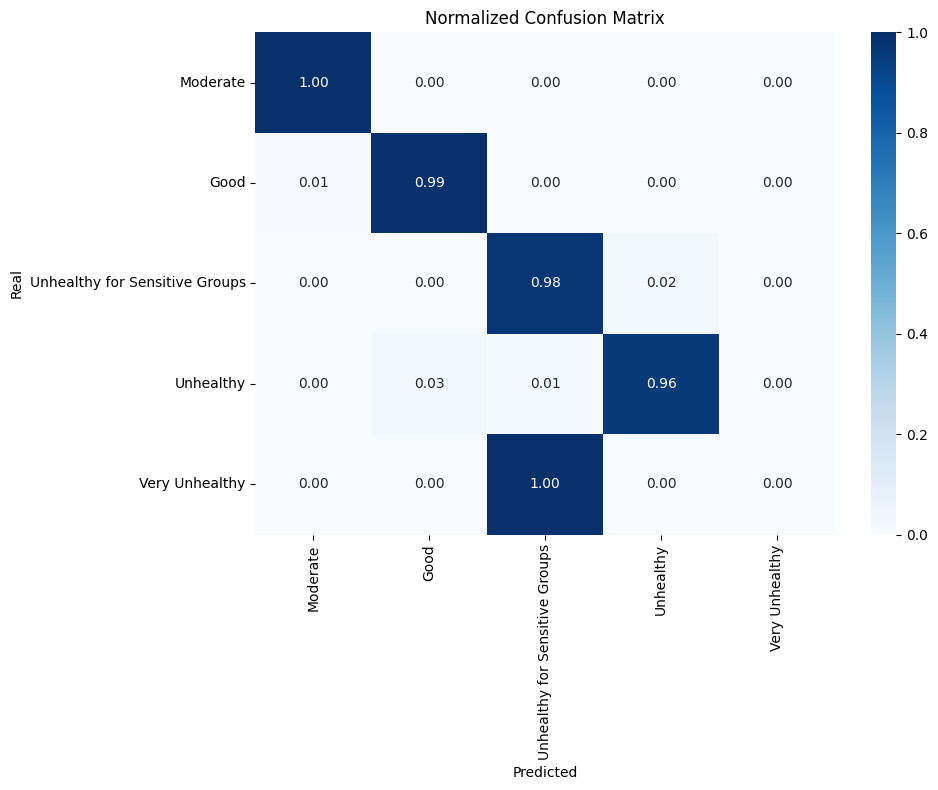

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_idx, y_pred, normalize="true")
plt.figure(figsize=(10,8))

sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

### Loss Trend During Training
**What the code does**
- `history.history['loss']` contains the loss calculated on the training set at each epoch.
- `history.history['val_loss']` contains the loss calculated on the validation set, data never seen during training.
- `plt.plot` draws the two curves: one for training and one for validation.

**How to read the graph**
- The x-axis represents the epochs (the number of times the model sees the entire training dataset).
- The y-axis represents the loss, i.e., the error measure the model tries to minimize.
  - *Blue curve (Training Loss):* shows how the model adapts to the training data.
  - *Orange curve (Validation Loss):* indicates how well the model generalizes to unseen data.

**Interpreting the results**
- The validation loss remains very low and stable throughout all epochs --> the model generalizes well.
- The training loss starts very high, drops sharply in the first epochs, and then stabilizes --> the model quickly learned to capture the data structure.
- The absence of divergence between training and validation loss suggests that there is no significant overfitting: the model is not memorizing the data but has learned useful rules that apply to new cases.


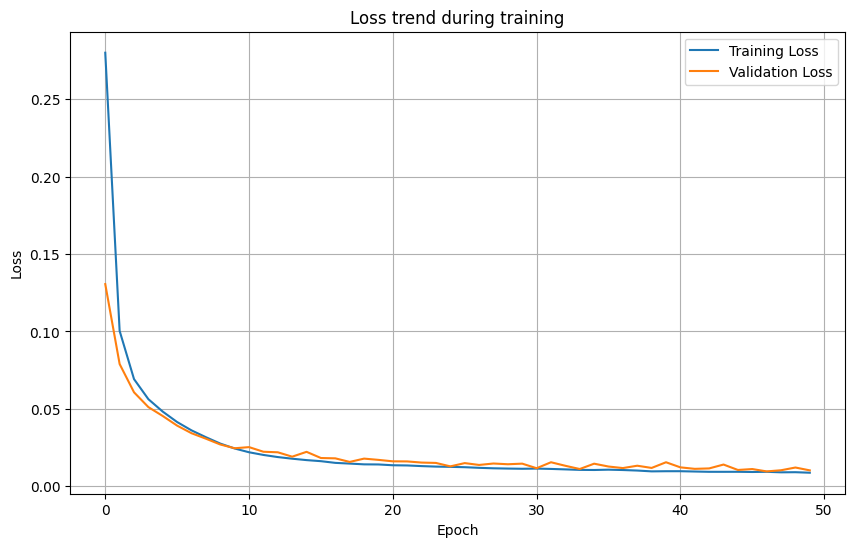

In [ ]:
# Visualization of the loss trend
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss trend during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()


### Validation Accuracy Trend
**What the code does**
- `history.history['accuracy']` contains the accuracy calculated on the training set at each epoch.
- `history.history['val_accuracy']` contains the accuracy calculated on the validation set at each epoch.
- `plt.plot` draws the validation accuracy curve.

**How to read the graph**
- The x-axis shows the epochs (number of complete passes over the training dataset).
- The y-axis shows the Validation Accuracy (the percentage of correct predictions on unseen data).
  - *Blue curve (Training Accuracy):* shows how much accurate the model is for the training data.
  - *Orange curve (Validation Accuracy):* represents the trend of this metric during training.

**Interpreting the results**
- Validation accuracy is more unstable.
- After the first ~10 epochs, both curves stabilizes and continue to rise.
- This trend indicates that the model progressively improves its generalization ability and maintains excellent performance on new instances while it improves on training examples.


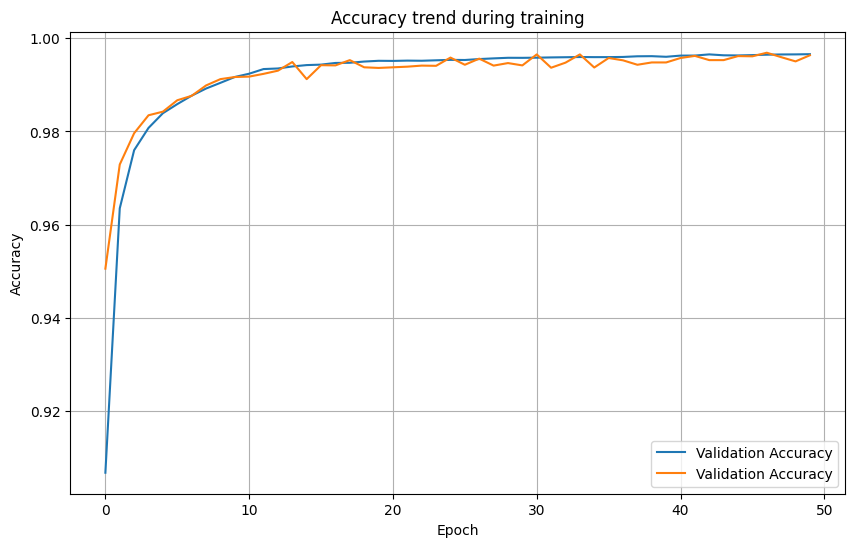

In [ ]:
# Visualization of the validation accuracy trend
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy trend during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

## Exercise 1
Group the classes considering the following logic:

1. `poor` quality for Very Unhealthy, and Unhealthy

2. `low but tolerable` quality for the general population

3. `moderate` quality

4. `good` quality

Then create a network, train for 10 epochs and evaluate it, and build the confusion matrix.

In [ ]:
# Copy of y lists
y_train_group = y_train.copy()
y_val_group   = y_val.copy()
y_test_group  = y_test.copy()

# Grouping Logic
logic = {
            "Very Unhealthy": "Poor",
            "Unhealthy": "Poor"
        }

### Solution 1

In [ ]:
# Conversion of categorical columns into numeric
y_train_group = y_train_group.replace(logic)

y_val_group = y_val_group.replace(logic)

y_test_group = y_test_group.replace(logic)

print("\nStats for y train:")
print(y_train_group.value_counts(dropna=False))
print("\nStats for y val:")
print(y_val_group.value_counts(dropna=False))
print("\nStats for y test:")
print(y_test_group.value_counts(dropna=False))

print("\nUnique values in the 'status' column after initial loading:")
class_names_ex2 = y_train_group.unique()
num_classes_ex2=len(y_train_group.unique())
print(class_names_ex2)
print("\nNumber of classes:", num_classes_ex2)

# Numeric encoding
encoder = LabelEncoder()
encoder.fit(y_train_group)
y_train_group_idx = encoder.transform(y_train_group)
y_val_group_idx   = encoder.transform(y_val_group)
y_test_group_idx  = encoder.transform(y_test_group)

# One-hot encoding
y_train_group_oh = to_categorical(y_train_group_idx, num_classes=num_classes_ex2)
y_val_group_oh = to_categorical(y_val_group_idx, num_classes=num_classes_ex2)
y_test_group_oh = to_categorical(y_test_group_idx, num_classes=num_classes_ex2)



Stats for y train:
status
Good                              149108
Moderate                           46245
Unhealthy for Sensitive Groups      2759
Poor                                 185
Name: count, dtype: int64

Stats for y val:
status
Good                              16605
Moderate                           5115
Unhealthy for Sensitive Groups      296
Poor                                 17
Name: count, dtype: int64

Stats for y test:
status
Good                              41376
Moderate                          12960
Unhealthy for Sensitive Groups      704
Poor                                 43
Name: count, dtype: int64

Unique values in the 'status' column after initial loading:
['Good' 'Moderate' 'Unhealthy for Sensitive Groups' 'Poor']

Number of classes: 4


Epoch 1/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8594 - loss: 0.4073 - val_accuracy: 0.9618 - val_loss: 0.1053
Epoch 2/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9693 - loss: 0.0875 - val_accuracy: 0.9805 - val_loss: 0.0625
Epoch 3/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9812 - loss: 0.0566 - val_accuracy: 0.9844 - val_loss: 0.0497
Epoch 4/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9848 - loss: 0.0450 - val_accuracy: 0.9867 - val_loss: 0.0426
Epoch 5/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9872 - loss: 0.0399 - val_accuracy: 0.9879 - val_loss: 0.0371
Epoch 6/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9878 - loss: 0.0357 - val_accuracy: 0.9894 - val_loss: 0.0344
Epoch 7/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9899 - loss: 0.0304 - val_accuracy: 0.9870 - val_loss: 0.0346
Epoch 8/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9901 - loss: 0.0279 - 

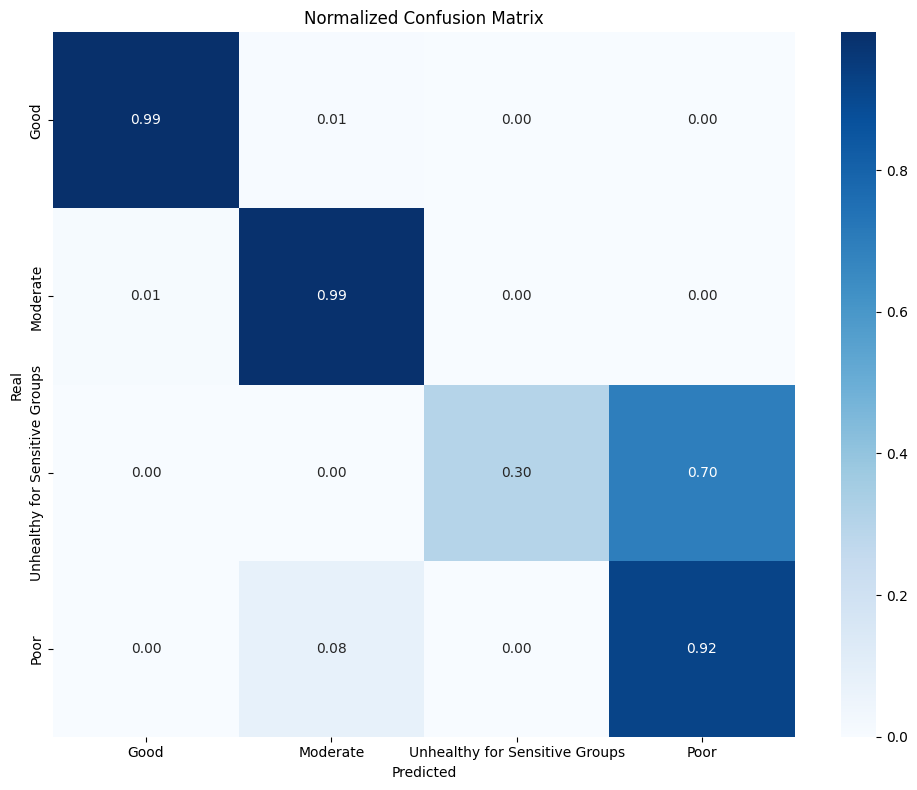

In [ ]:
# Define the model
model_group = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(num_classes_ex2, activation="softmax")
])

# Model filling
model_group.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Model training
history = model_group.fit(
    X_train, y_train_group_oh,
    validation_data=(X_val, y_val_group_oh),
    epochs=10,
    batch_size=128,
    verbose=1
)

# Model evaluation on the test set
loss_group, acc_group = model_group.evaluate(X_test, y_test_group_oh, verbose=0)
print(f"Test Accuracy: {acc_group:.4f}")

# Predictions on the test set
y_pred_group = model_group.predict(X_test, verbose=0).argmax(axis=1)

# Confusion matrix
cm_group = confusion_matrix(y_test_group_idx, y_pred_group, normalize="true")
plt.figure(figsize=(10,8))

sns.heatmap(cm_group, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names_ex2, yticklabels=class_names_ex2)
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

## Exercise 2
Compare test accuracy on networks with different architectures with increasing number of neurons.

- Consider a simpler network consisting of only one hidden layer (so, the netwrok will have the input layer, one intermediate Dense layer and the output layer).

- The number of neurons is defined in `n_hidden_neurons`.

- Use grouped version of `y_\*_group` created in **Exercise 1**

### Exercise 2.a: Setting Parameters for the Analysis
We set:
- different values of `n_hidden_neurons` from 2 to 32

In [ ]:
# Definition fo the other parameters
n_hidden_neurons  = [2, 4, 8, 16, 32]
accuracy_list = []

### Exercise 2.b: Loop over n_hidden_neurons
For each value of `n_hidden_neurons` create and train  for 10 epochs the corresponding network and compute its accuracy.

In [ ]:
# for each n_hidden_neuron in n_hidden_neurons:

    # Build the model

    # Model filling

    # Evaluate the model

    # Append test accuracy in accuracy_list


### Solution 2.b

In [ ]:
# for each n_hidden_neuron in n_hidden_neurons:
for n_hidden_neuron in n_hidden_neurons:

    print(f"\n\nNetwork with n. of neurons in hidden layer: {n_hidden_neuron}")

    # Build the model
    model_ex2 = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(n_hidden_neuron, activation="relu"),
        layers.Dense(num_classes_ex2, activation="softmax")
    ])

    # Model filling
    model_ex2.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Model training
    history = model_ex2.fit(
        X_train, y_train_group_oh,
        validation_data=(X_val, y_val_group_oh),
        epochs=10,
        batch_size=128,
        verbose=1
    )

    # Evaluate the model
    loss_ex2, acc_ex2 = model_ex2.evaluate(X_test, y_test_group_oh, verbose=0)
    print(f"Test Accuracy (n. neurons {n_hidden_neuron}): {acc_ex2:.4f}")

    # Append test accuracy in accuracy_list
    accuracy_list.append(acc_ex2)




Network with n. of neurons in hidden layer: 2
Epoch 1/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7307 - loss: 0.8369 - val_accuracy: 0.9115 - val_loss: 0.2857
Epoch 2/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9219 - loss: 0.2557 - val_accuracy: 0.9379 - val_loss: 0.1927
Epoch 3/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9419 - loss: 0.1831 - val_accuracy: 0.9490 - val_loss: 0.1508
Epoch 4/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9505 - loss: 0.1466 - val_accuracy: 0.9585 - val_loss: 0.1304
Epoch 5/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9572 - loss: 0.1296 - val_accuracy: 0.9587 - val_loss: 0.1188
Epoch 6/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9607 - loss: 0.1166 - val_accuracy: 0.9613 - val_loss: 0.1101
Epoch 7/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9633 - loss: 0.1069 - val_accuracy: 0.9647 - val_loss: 0.1033
Epoch 8/10
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 

### Exercise 2.c: Plot Accuracy vs n_hidden_neurons
Visually compare model performance as the number of neurons of the hidden layer varies.

In [ ]:
# Create the plot

# Plot the accuracy

# Personalize the plot

# Show the plot


### Solution 2.c

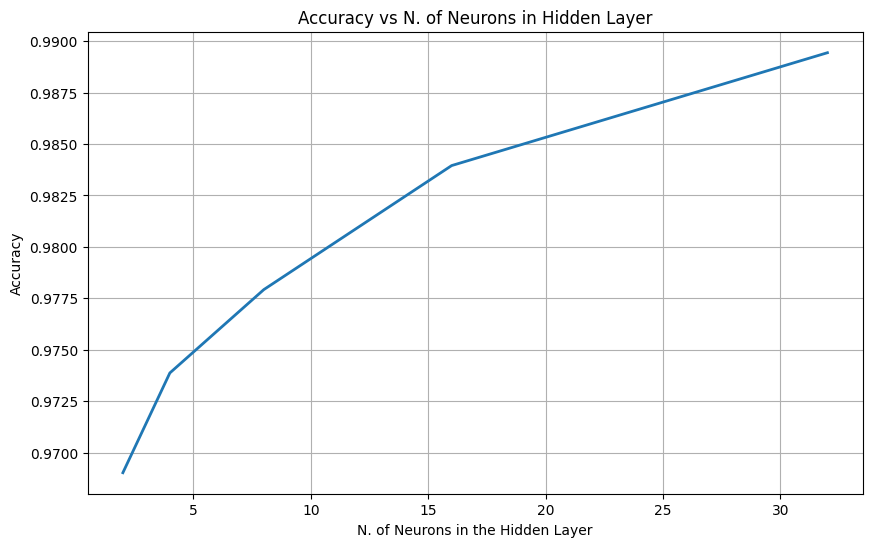

In [ ]:
# Create the plot
plt.figure(figsize=(10,6))

# Plot the accuracy
plt.plot(n_hidden_neurons, accuracy_list, linewidth=2)

# Personalize the plot
plt.xlabel("N. of Neurons in the Hidden Layer")
plt.ylabel("Accuracy")
plt.title("Accuracy vs N. of Neurons in Hidden Layer")
plt.grid(True)

# Show the plot
plt.show()

## Exercise 3
Try to implement and train a network considering the whole dataset.
To do so, you must reload the dataset into a new dataframe maintaining all the rows.

In [7]:
# Load whole dataset
df_ex3 = pd.read_csv(file_path, low_memory=False, na_values=['-', 'NA', 'n/a', 'ND',''])

# Print checks
print(df_ex3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5882208 entries, 0 to 5882207
Data columns (total 25 columns):
 #   Column     Dtype  
---  ------     -----  
 0   date       object 
 1   sitename   object 
 2   county     object 
 3   aqi        float64
 4   pollutant  object 
 5   status     object 
 6   so2        float64
 7   co         float64
 8   o3         float64
 9   o3_8hr     float64
 10  pm10       float64
 11  pm2.5      float64
 12  no2        float64
 13  nox        float64
 14  no         float64
 15  windspeed  float64
 16  winddirec  float64
 17  unit       float64
 18  co_8hr     float64
 19  pm2.5_avg  float64
 20  pm10_avg   float64
 21  so2_avg    float64
 22  longitude  float64
 23  latitude   float64
 24  siteid     float64
dtypes: float64(20), object(5)
memory usage: 1.1+ GB
None


In [8]:
#identifico target
target='status'
#elimino colonne con target nullo
df_ex3=df_ex3.dropna(subset=[target])
#identifico numero di classi(numero neuroni ultimo livello rete)
num_class=len(df_ex3[target].unique())
#rimuovo colonne non numeriche inutili per la rete neurale
dropped=["sitename", "county","aqi","unit","siteid","pollutant","date"]
df_ex3=df_ex3.drop(columns=dropped)
#seleziono colonne numeriche e creo lista
numeric=df_ex3.select_dtypes(include=['number']).columns.tolist()
#elimino righe con valori nulli in quelle colonne
df_ex3.dropna(subset=numeric,inplace=True,how='any')

In [9]:
#primo split del dataframe in train e test
train_df,test_df=train_test_split(df_ex3,test_size=0.2,random_state=42)
#secondo split del train in train e val
train_df,val_df=train_test_split(train_df,test_size=0.1,random_state=42)
#prendo da questi dataset 3 array per le feature e 3 array per i target
y_train_ex3=train_df[target]
y_val_ex3=val_df[target]
y_test_ex3=test_df[target]
x_train_ex3=train_df.drop(columns=target)
x_val_ex3=val_df.drop(columns=target)
x_test_ex3=test_df.drop(columns=target)
#oppure x_train_ex3=df_ex3[numeric].values
#label encoder sui  target con classe (fit su train e transform su tutti)
encoder = LabelEncoder()
encoder.fit(y_train_ex3)
y_train_ex3_idx = encoder.transform(y_train_ex3)
y_val_ex3_idx = encoder.transform(y_val_ex3)
y_test_ex3_idx = encoder.transform(y_test_ex3)
#one hot encoding sui target con to_categorical
y_train_ex3_oh = to_categorical(y_train_ex3_idx, num_classes=num_class)
y_val_ex3_oh = to_categorical(y_val_ex3_idx, num_classes=num_class)
y_test_ex3_oh = to_categorical(y_test_ex3_idx, num_classes=num_class)
#effettuo anche standardizzazione sulle feature con StandardScaler su tutte
scaler=StandardScaler()
x_train_ex3=scaler.fit_transform(x_train_ex3)
x_val_ex3=scaler.transform(x_val_ex3)
x_test_ex3=scaler.transform(x_test_ex3)

In [11]:
#definisco rete con keras.Sequential
model=keras.Sequential([
    layers.Input(shape=(x_train_ex3.shape[1],)),
    layers.Dense(16,activation='relu'),
    layers.Dense(8,activation='relu'),
    layers.Dense(num_class,activation='softmax')
])
#compilo rete con optimizer,loss e metrics
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
#traino la rete con fit e ottengo history
history=model.fit(
    x_train_ex3,y_train_ex3_oh,
    validation_data=(x_val_ex3,y_val_ex3_oh),
    epochs=25,
    batch_size=128,
    verbose=1
)
#evaluation con dati di test x e y
loss,acc=model.evaluate(x_test_ex3,y_test_ex3_oh)
print(f"Test Accuracy: {acc:.4f}")
#predizione y con dati x di test
y_pred=model.predict(x_test_ex3).argmax(axis=1)

Epoch 1/25
24137/24137 ━━━━━━━━━━━━━━━━━━━━ 23s 920us/step - accuracy: 0.9430 - loss: 0.1730 - val_accuracy: 0.9910 - val_loss: 0.0291
Epoch 2/25
24137/24137 ━━━━━━━━━━━━━━━━━━━━ 23s 930us/step - accuracy: 0.9923 - loss: 0.0255 - val_accuracy: 0.9941 - val_loss: 0.0223
Epoch 3/25
24137/24137 ━━━━━━━━━━━━━━━━━━━━ 22s 897us/step - accuracy: 0.9939 - loss: 0.0201 - val_accuracy: 0.9954 - val_loss: 0.0169
Epoch 4/25
24137/24137 ━━━━━━━━━━━━━━━━━━━━ 22s 901us/step - accuracy: 0.9945 - loss: 0.0173 - val_accuracy: 0.9948 - val_loss: 0.0172
Epoch 5/25
24137/24137 ━━━━━━━━━━━━━━━━━━━━ 22s 919us/step - accuracy: 0.9948 - loss: 0.0160 - val_accuracy: 0.9924 - val_loss: 0.0204
Epoch 6/25
24137/24137 ━━━━━━━━━━━━━━━━━━━━ 22s 911us/step - accuracy: 0.9951 - loss: 0.0152 - val_accuracy: 0.9946 - val_loss: 0.0170
Epoch 7/25
24137/24137 ━━━━━━━━━━━━━━━━━━━━ 22s 911us/step - accuracy: 0.9954 - loss: 0.0141 - val_accuracy: 0.9956 - val_loss: 0.0139
Epoch 8/25
24137/24137 ━━━━━━━━━━━━━━━━━━━━ 22s 899us/s

In [12]:
#creo matrice di confusione con dati di test e predetti
cm=confusion_matrix(y_test_ex3,y_pred)
#uso sns.heatmap per plottare e matplotlib per mostrare grafico
sns.heatmap(cm,annot=True,fmt='.2f',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()
#plot di loss val_loss accurac e val_accuracy con diverse label
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Loss trend during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy trend during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

ValueError: Mix of label input types (string and number)